In [1]:
    from IPython.display import HTML

    hide_me = ''
    HTML('''<script>
      function code_toggle() {
        if (code_shown){
          $('div.input').hide('500');
          $('#toggleButton').val('Show Code')
        } else {
          $('div.input').show('500');
          $('#toggleButton').val('Hide Code')
        }
        code_shown = !code_shown
      }

      $( document ).ready(function(){
        code_shown=false;
        $('div.input').hide()
      });
    </script>
    <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


Notes from talking with John Selker are <mark>highlighted</mark>.

# 1) Goals of the Vertical Harp Spectral Response Kloendeel Experiment

1) Implementing the dynamic calibration from Hausner et al., 2011.  

2) Understand the spectral response of the DTS cables/instruments (Ultima and XT) to be used for the DarkMix project in comparison to eddy-covariance observations. Effectively, we are testing the cables by reproducing Figure 4 from Thomas et al. 2012.  

# 2) Methods

## Experimental design
See the below figure for a sketch of the experiment.

## Dynamic recalibration of DTS observations using "raw" observations

Following Hausner et al. we calibrate the temperature by inverting the matrices in equation 3. Since we have 4 baths at 2 temperatures and 4 distances, we can calibrate with 3 bath sections and withhold the 4th for validation.

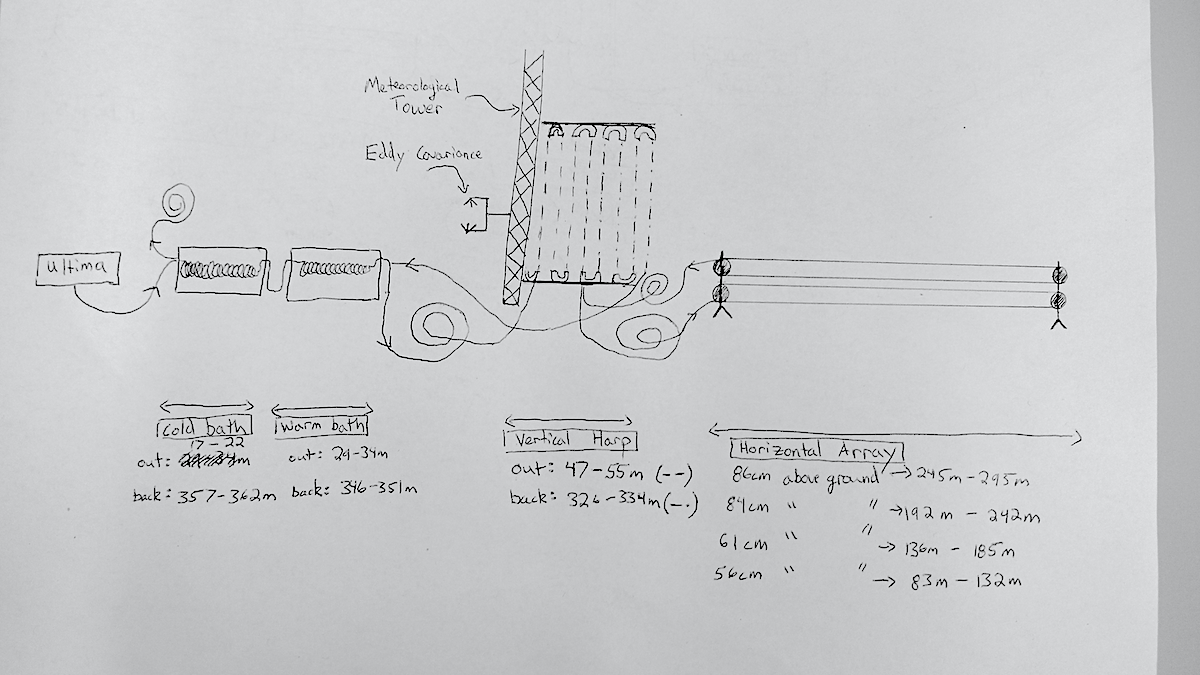

In [2]:
from IPython.core.display import Image 
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/VertHarp.ExpDesign.jpg')


#### Sketch of the experimental set-up.
The Ultima is sampling a ~400m length of cable in a single-ended configuration. The cable runs runs out and then back, where it rests on the spool.
- On both the out and back the cable runs through a cold bath (which given our lack of ice is more of an ambient temperature bath) and a warm bath (~40C).
- On the tower we set up a vertical array of fiber optic cable to allow us to directly compare the eddy-covariance- and Ultima-derived temperatures. 
- We then run the cable out on a horizontal array, largely just to eat up cable before running the cable back to the vertical harp. 
- The main goal was to acquire a "near-Ultima" and "further-away-from-Ultima" comparison to understand how signal attenuation affects the spectral response of temperature observations.

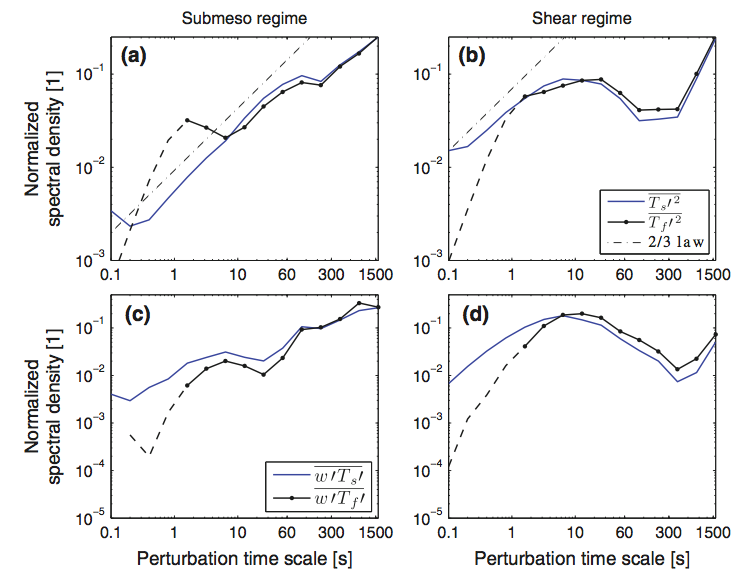

In [3]:
# @hidden_cell
from IPython.core.display import Image 
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/Thomas2011.Fig4.png')


### Figure 4 from Thomas et al., 2012

(a-b) Spectral response of eddy-covariance (blue) and DTS (black dots) for (a) the submeso, weak wind regime and (b) for the shear, convective regime. (c-d) Same but for the sensible heat flux -- not directly relevant for this analysis.

We are aiming to recreate (a-b) using the Ultima and XT data that we gathered this summer.

In [4]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [5]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_UltimaVHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_UltimaVHSRE_processed'

In [6]:
#########################
## Load processed data ##
#########################
os.chdir(dirProcessed)
ncFiles = ['VHRSE_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 16)]
ds = xr.open_mfdataset(ncFiles)
ds.attrs['locations'] = ds.attrs['locations'].split(';')

# 3) Data quality issues

- The manual calibration following Hausner et al.(2011) can yield awful validation results.
- It is unclear where we are running into this issue.

### Data quality checks

First step is to search for step losses, as these seem like the most probable explanation for why the manual calibration is having issues.

In [7]:
location = {

    ########################
    ## Near vertical harp ##
    ########################
    'vertHarpNear' : [47.3, 54.9],

    #######################
    ## Far vertical harp ##
    #######################
    # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
    # tentatively assign 326.2 to 327.7 as the upward limb.
    'vertHarpFar': [326.2, 333.75],


    ######################
    ## Horizontal Array ##
    ######################
    'Horizontal - 86cm': [245, 294.5],
    'Horizontal - 84cm': [192.25, 242],
    'Horizontal - 60.5cm': [136, 185.5],
    'Horizontal - 56cm': [82.5, 132],

    #######################
    ## Temperature Baths ##
    #######################
    'warmBathNear': [29, 34],
    'coldBathNear': [17, 22],
    'warmBathFar': [346, 351],
    'coldBathFar': [357, 362],
    }

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


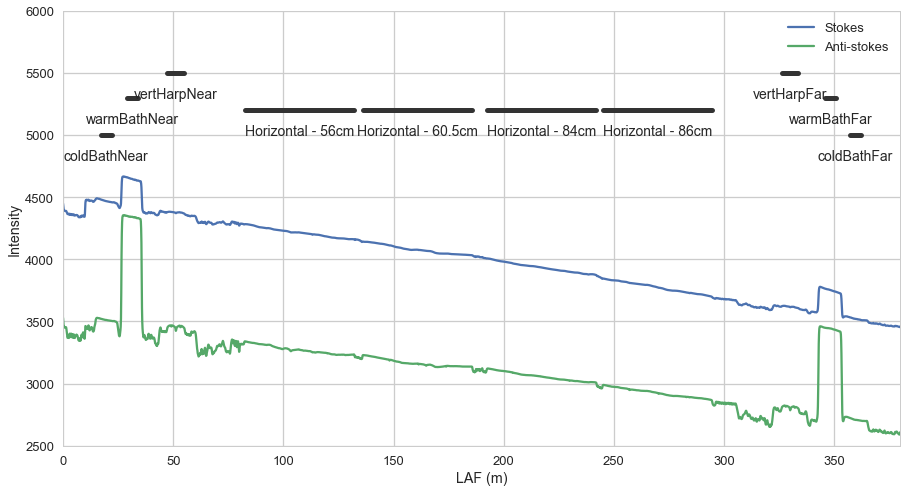

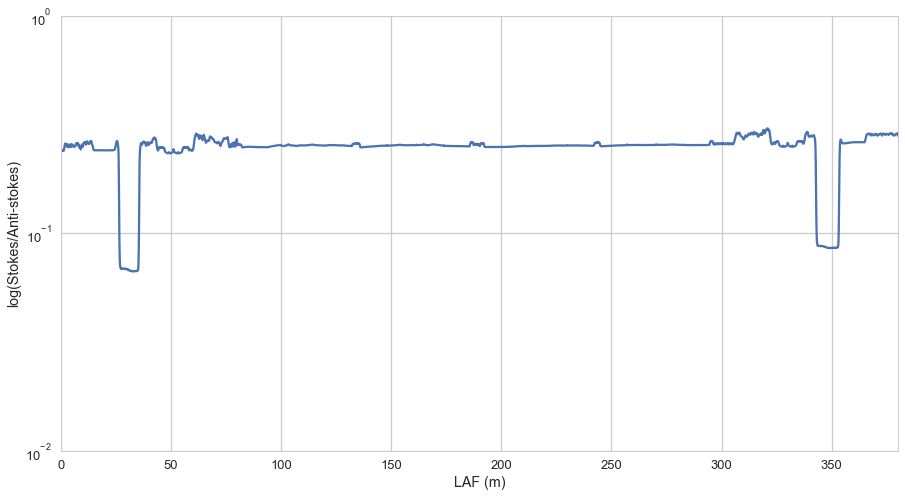

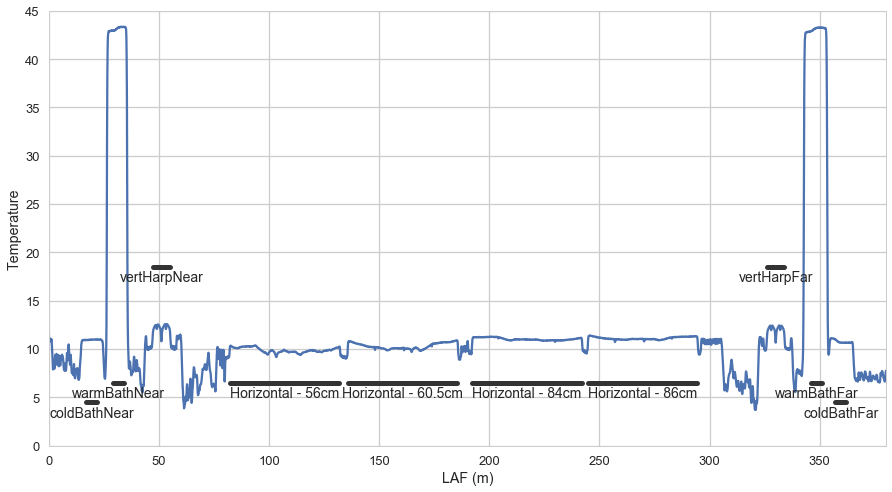

In [26]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 0)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    if 'cold' in l:
        ypos = 4800
    elif 'warm' in l:
        ypos = 5100
    elif 'Harp' in l:
        ypos = 5300
    else:
        ypos = 5000
    plt.plot([location[l][0], location[l][1]], [ypos + 200, ypos + 200], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, ypos,
             l, horizontalalignment='center', fontsize=14)

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.semilogy(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(10**(-2), 1)
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    if 'cold' in l:
        ypos = 3
    elif 'warm' in l:
        ypos = 5
    elif 'Harp' in l:
        ypos = 17
    else:
        ypos = 5
    plt.plot([location[l][0], location[l][1]], [ypos + 1.5, ypos + 1.5], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, ypos,
             l, horizontalalignment='center', fontsize=14)

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], 380)
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')



### Looking for step losses

Time-averaged quantities along the fiber. The fiber was only ~400m long.

Are there step losses? It is not clear to me. (Pardon the terrible labeling, just needed something quick and dirty).

The blips in the returned power within the horizontal array are the contact points of the fiber against the disks. In between the labeled sections, the fiber was gently spooled on the ground.

The only splice was to a pig-tail that between the Ultima and the length of fiber. This is located at ~2m, shown below along with the first two calibration baths.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


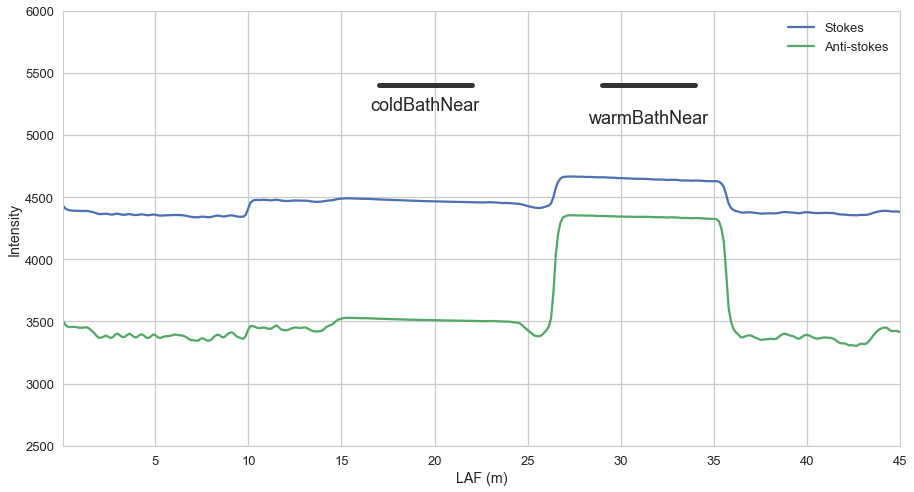

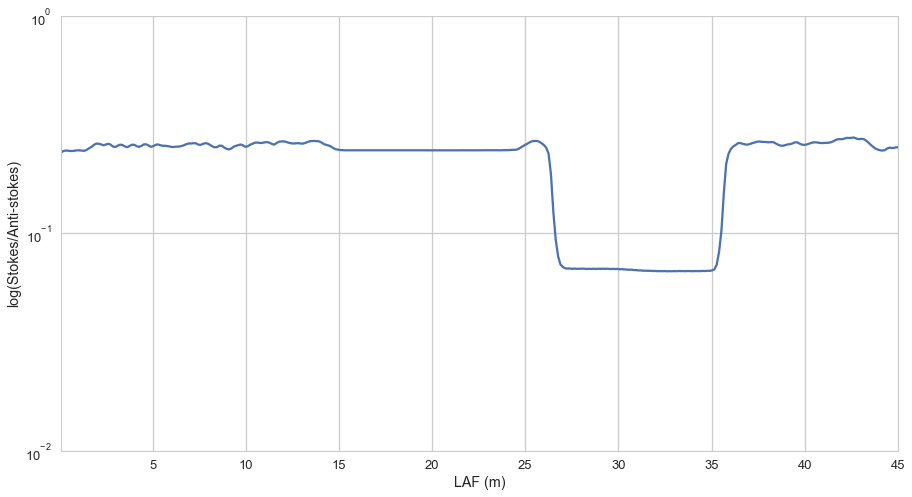

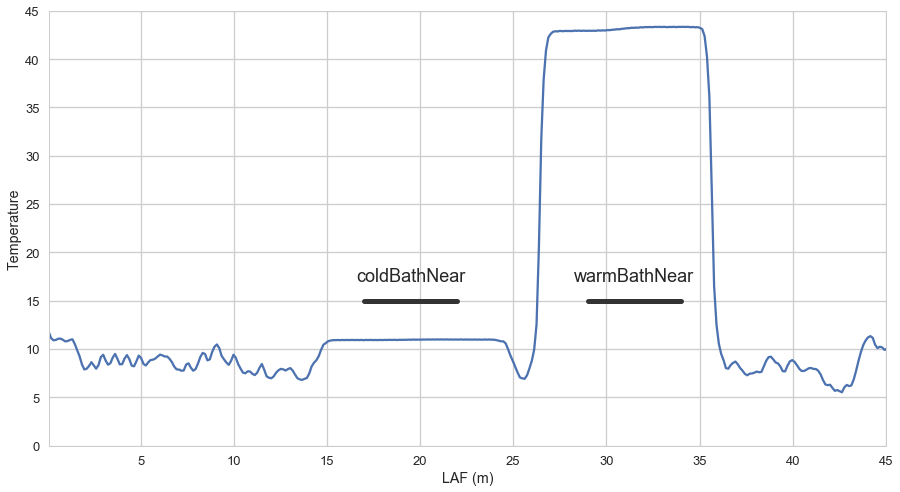

In [9]:
# Stokes and Anti-stokes intensities
startIndex = np.flatnonzero(ds.LAF.values > 0)[0]
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.Ps.mean(dim='time'), label='Stokes')
plt.plot(ds.LAF, ds.Pas.mean(dim='time'), label='Anti-stokes')

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [5400, 5400], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 4500 + nl * 100,
             l, horizontalalignment='center', fontsize=18)

plt.gca().set_ylim(2500, 6000)
plt.gca().set_ylabel('Intensity')
plt.gca().set_xlabel('LAF (m)')
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.legend()

# Log ratio of stokes:anti-stokes
plt.figure(figsize=(15, 8))
plt.semilogy(ds.LAF, np.log(ds.Ps / ds.Pas).mean(dim='time'))
plt.gca().set_ylim(10**(-2), 1)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('log(Stokes/Anti-stokes)')
plt.gca().set_xlabel('LAF (m)')

# Instrument reported temperatures
plt.figure(figsize=(15, 8))
plt.plot(ds.LAF, ds.temp.mean(dim='time'))

for nl, l in enumerate(location):
    if 'BathNear' not in l:
        continue
    plt.plot([location[l][0], location[l][1]], [15, 15], color='0.2', linewidth=5)
    plt.text((location[l][1] + location[l][0]) / 2, 17,
             l, horizontalalignment='center', fontsize=18)

plt.gca().set_ylim(0, 45)
plt.gca().set_xlim(ds.LAF[startIndex], 45)
plt.gca().set_ylabel('Temperature')
plt.gca().set_xlabel('LAF (m)')



### Zooming in on the temperature baths (will be relevant later)
- There appears to be a temperature increase in the instrument reported temperatures (lower plot), but there is no clear increase in the $ln(\frac{P_{stokes}}{P_{anti-stokes}})$ (upper plot).
- We have no reason to believe that anything about the fiber varies from one end of the bath to the other.
- Similarly, the baths were mixed using aquarium pumps.
- The only obvious step loss (at least to me) is the splice at 2ish meters along fiber.

<mark>The splice does not appear to be a problem.</mark>


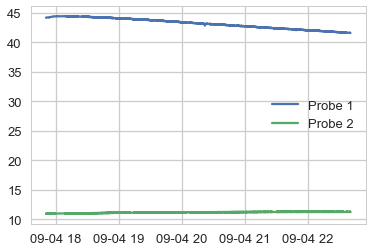

In [10]:
# Temperature probes are unlabeled, determine which bath each was measuring
plt.plot(ds.time, ds['probe1Temperature'], label='Probe 1')
plt.plot(ds.time, ds['probe2Temperature'], label='Probe 2')
plt.legend()

- probe1Temperature is the warm bath
- probe2Temperature is the cold bath

Future versions of read/processing code will somehow need to do affiliate each probe temperature with the bath name for the below calibration to function.

In [11]:
# Reference temperatures
refField1 = 'probe1Temperature' # Warm bath
refField2 = 'probe2Temperature' # Cold bath
refField3 = 'probe1Temperature' # Warm bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'warmBathFar'
refLoc2 = 'coldBathFar'
refLoc3 = 'warmBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]

 Time step 14999 of 15000ime step 3468 of 15000Time step 7061 of 15000Time step 11728 of 15000

# 4) Calibrated parameters
From the calibration routine, the calibrated parameters are shown below.

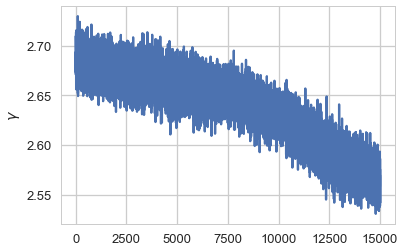

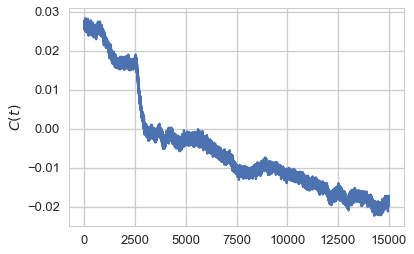

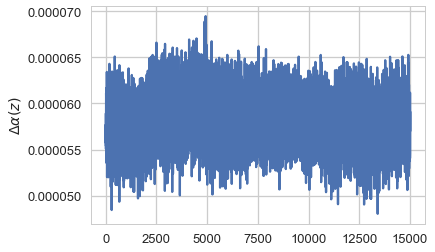

In [12]:
plt.plot(gamma)
plt.gca().set_ylabel('$\gamma$')

plt.figure()
plt.plot(C)
plt.gca().set_ylabel('$C(t)$')

plt.figure()
plt.plot(delta_alpha)
plt.gca().set_ylabel(r'$\Delta  \alpha (z)$')


Ok, the above values are now closer to what we would expect based on literature.
- $\gamma$ is supposed to be stable in both time and space and $O(100)$ (reported value for a different instrument is 400ish). 
- $C$ is expected to vary with time (I think)
- $\Delta \alpha$ is expected to be stable with time, excluding any breaking or bending of the wire. Note: $\Delta \alpha$ is expected to vary along the fiber. Future calibration may want to use an integrated term rather than the assumed constant.

<mark>- C(t) should not cross zero, that is weird.</mark>  
<mark>- $\gamma$ is too low</mark>  
<mark>- $\alpha$(t) is super noisy, suggests we should instead use the temporal average rather than letting the quantity jump each time step.</mark>


In [15]:
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
      
ds['manualTemp'] = (('time', 'LAF'), manualTemp)

 Time step 3 of 15000

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


 Time step 14999 of 15000ime step 7494 of 15000Time step 11282 of 15000Time step 13977 of 15000

# 5) Results

## Spatial evaluation
This is the calibrated temperature using the reference sections from the near and far warm bath and the far cold bath. Results are averaged in time and reported spatially.

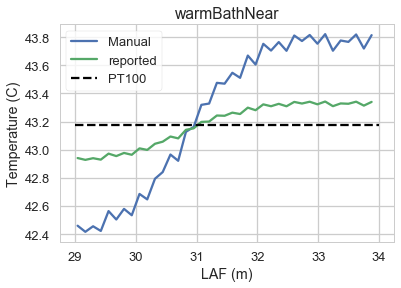

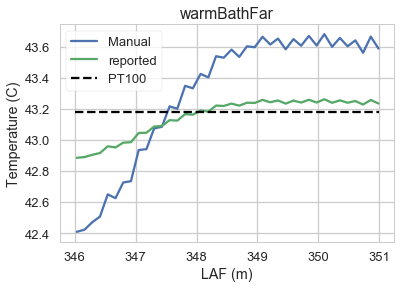

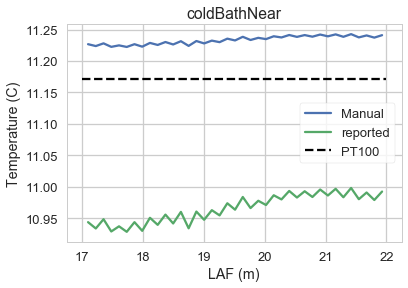

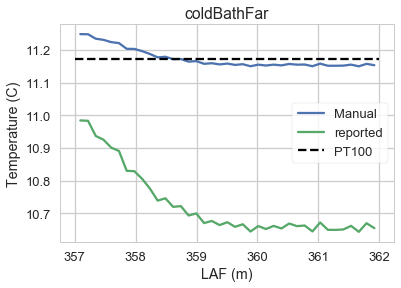

In [16]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


<mark>- There appears to be a really bad saw-tooth pattern. This needs further lab testing, since it is larger than sawtooth artefacts that John has encountered in other experiments.</mark>


## Temporal evaluation

Same as before except the results are spatially and reported as a function of time.

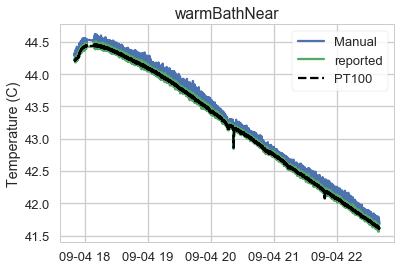

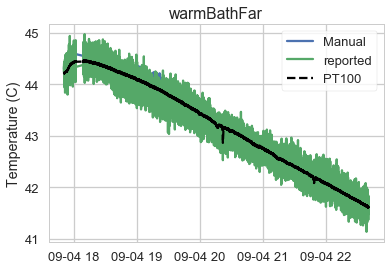

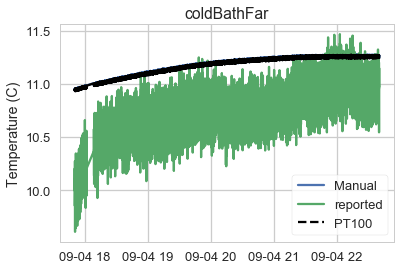

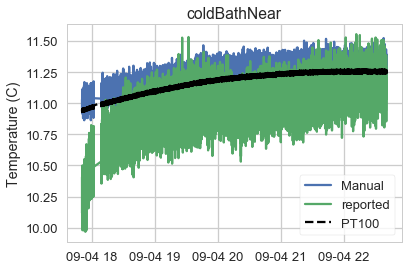

In [17]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

The calibrated temperatures absolutely nail the far and near warm baths, but have issues with the near cold bath (albeit with a better result than the instrument reported temperatures) but worse results for the near warm bath. This combination of reference sections yields the best results.

# 6) Re-calibrate using different reference sections

Calibration sections:
    - warm bath far
    - cold bath far
    - cold bath near

Validation section:
    - warm bath near

In [18]:
# Reference temperatures
refField1 = 'probe2Temperature' # Cold bath
refField2 = 'probe1Temperature' # Warm bath
refField3 = 'probe2Temperature' # Cold bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathFar'
refLoc2 = 'warmBathFar'
refLoc3 = 'coldBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]
    
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)

 Time step 3 of 150005000ime step 4905 of 15000Time step 12952 of 15000Time step 13568 of 15000

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in log


 Time step 14999 of 15000

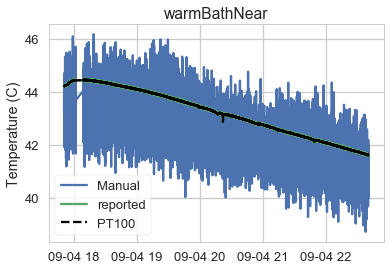

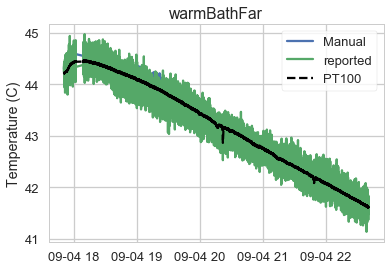

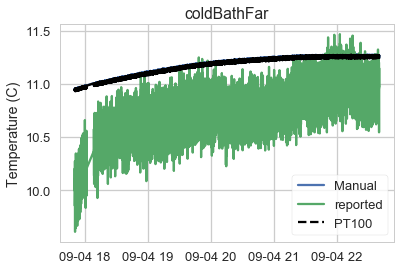

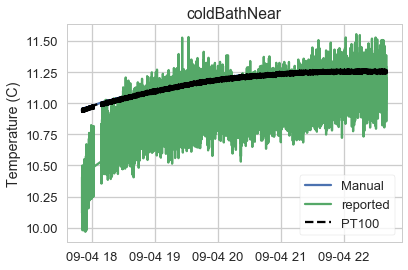

In [19]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

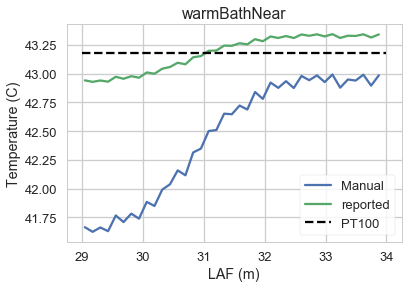

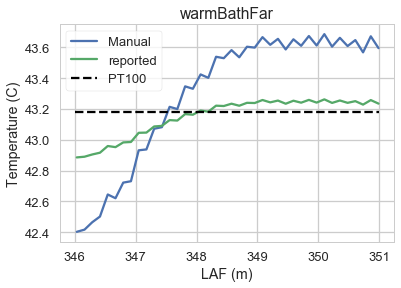

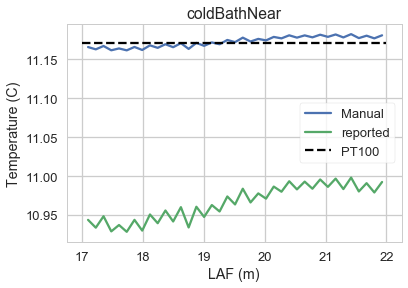

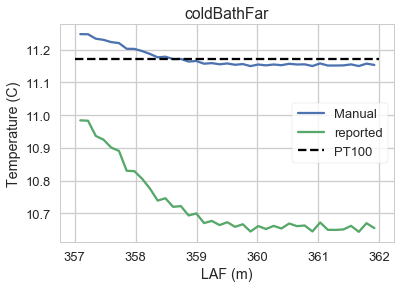

In [20]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


## Calibration using $\overline{\Delta \alpha (t)}$ (constant mean value)

In [ ]:
# Reference temperatures
refField1 = 'probe2Temperature' # Cold bath
refField2 = 'probe1Temperature' # Warm bath
refField3 = 'probe2Temperature' # Cold bath

refT1 = ds[refField1]
refT2 = ds[refField2]
refT3 = ds[refField3]

# Reference sections
refLoc1 = 'coldBathFar'
refLoc2 = 'warmBathFar'
refLoc3 = 'coldBathNear'

section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

ref_z1 = section1.LAF.mean(dim='location')
ref_z2 = section2.LAF.mean(dim='location')
ref_z3 = section3.LAF.mean(dim='location')

# Amplitudes of stokes/anti-stokes
stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

# Allocate the calibration variables
gamma = np.ones(np.shape(ds.time.values)) * -9999.
C = np.ones(np.shape(ds.time.values)) * -9999.
delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.

# Within each time step solve for the calibration parameters
for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")

    
    # A matrix
    A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
         [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
         [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
        ]

    # b matrix
    b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
         [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
         [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
        ]

    x = np.linalg.solve(A, b)
    
    gamma[n] = x[0]
    C[n] = x[1]
    delta_alpha[n] = x[2]
    
#############################
## Recalculate temperature ##
#############################
manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

for n, t in enumerate(ds.time):
    print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")
    manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)
    
ds['manualTemp'] = (('time', 'LAF'), manualTemp)

## Evaluations for after the clear offsets and spatial trends are accounted for

This is just a series of graphs showing the RMSE and bias for each calibration. I'm ignoring these until the head-scratcher issue in calibration is resolved.

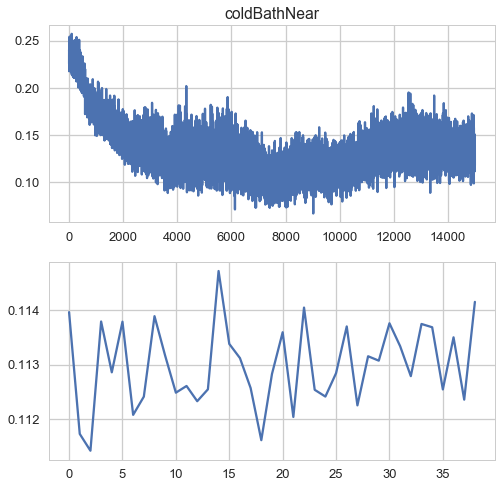

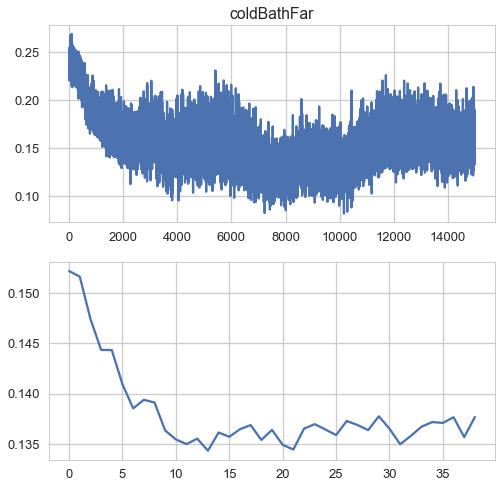

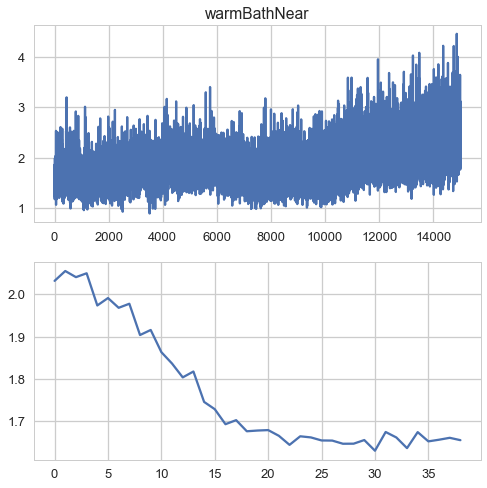

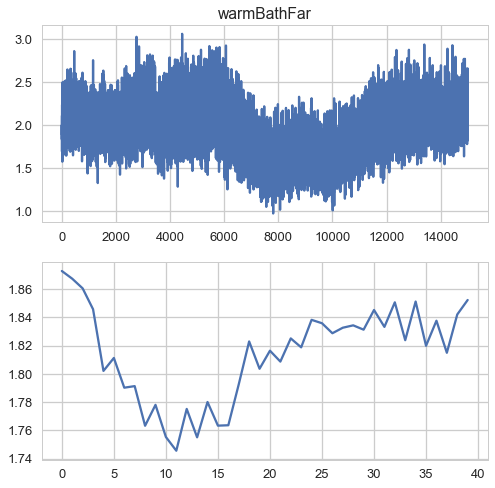

In [29]:
def rmse_ds_time(model, obs):
    return np.sqrt((model - obs) ** 2).mean(dim='time')

def rmse_ds_loc(model, obs):
    return np.sqrt((model - obs) ** 2).mean(dim='location')

loc = 'coldBathNear'
probe_ds = ds.probe2Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)
axes[0].set_title(loc)

loc = 'coldBathFar'
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)
axes[0].set_title(loc)

loc = 'warmBathNear'
probe_ds = ds.probe1Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)
axes[0].set_title(loc)

loc = 'warmBathFar'
probe_ds = ds.probe1Temperature
error_time = rmse_ds_time(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds)
error_loc = rmse_ds_loc(ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc), probe_ds.mean(dim='time'))

fig, axes = plt.subplots(2, 1, figsize=(8,8))
axes[0].plot(error_loc)
axes[1].plot(error_time)
axes[0].set_title(loc)


## Calibration bath pictures

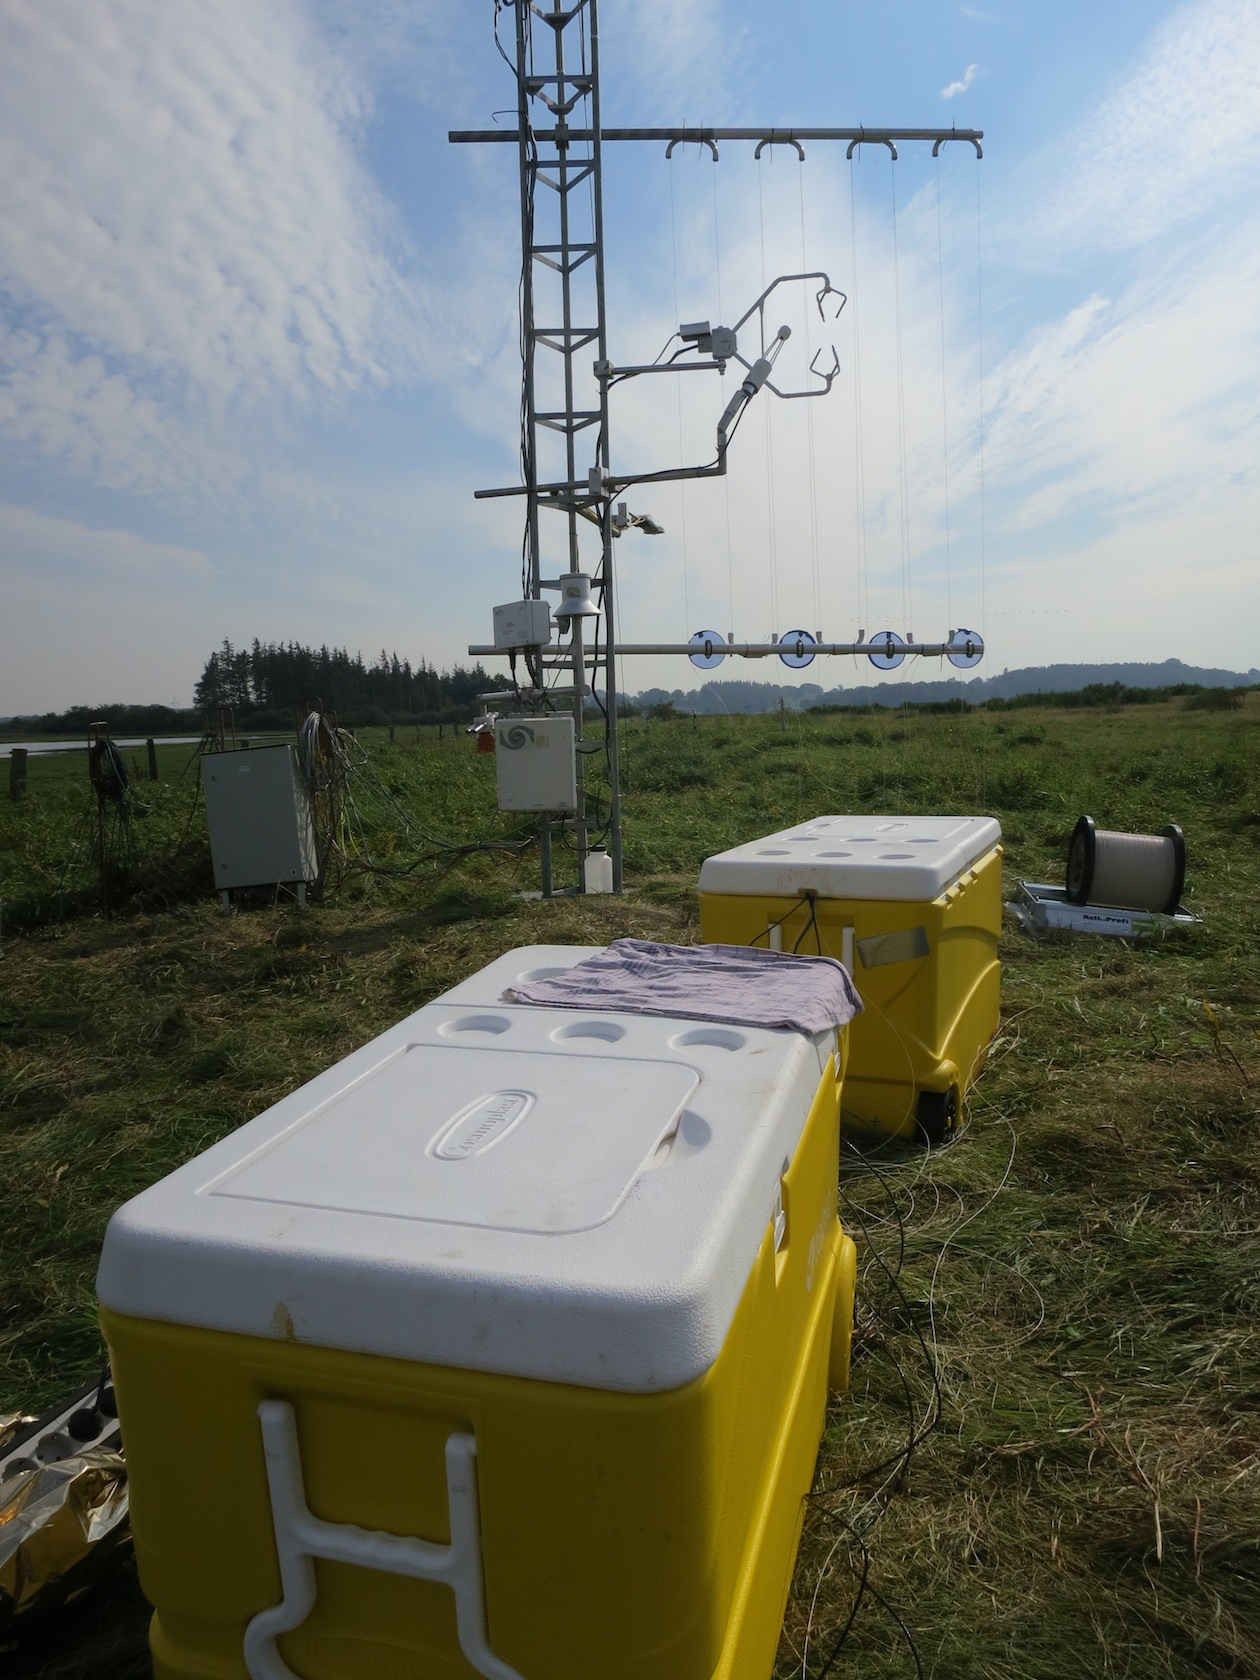

In [38]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/calibration_baths.small.JPG')


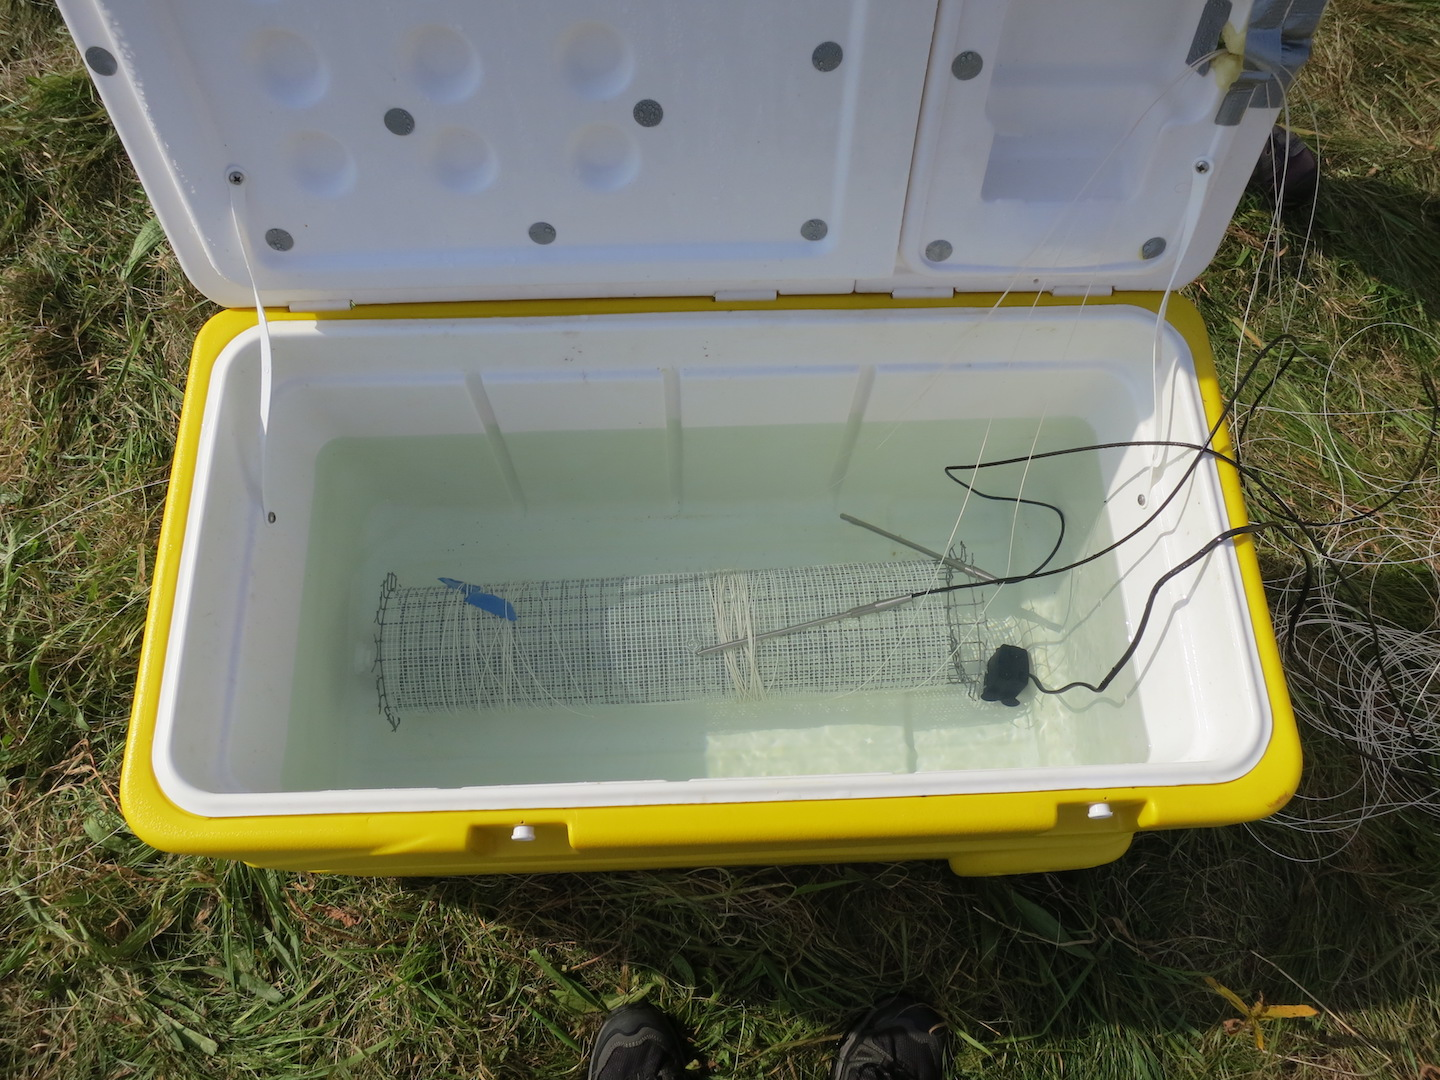

In [36]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/calibration_warm_bath.JPG')


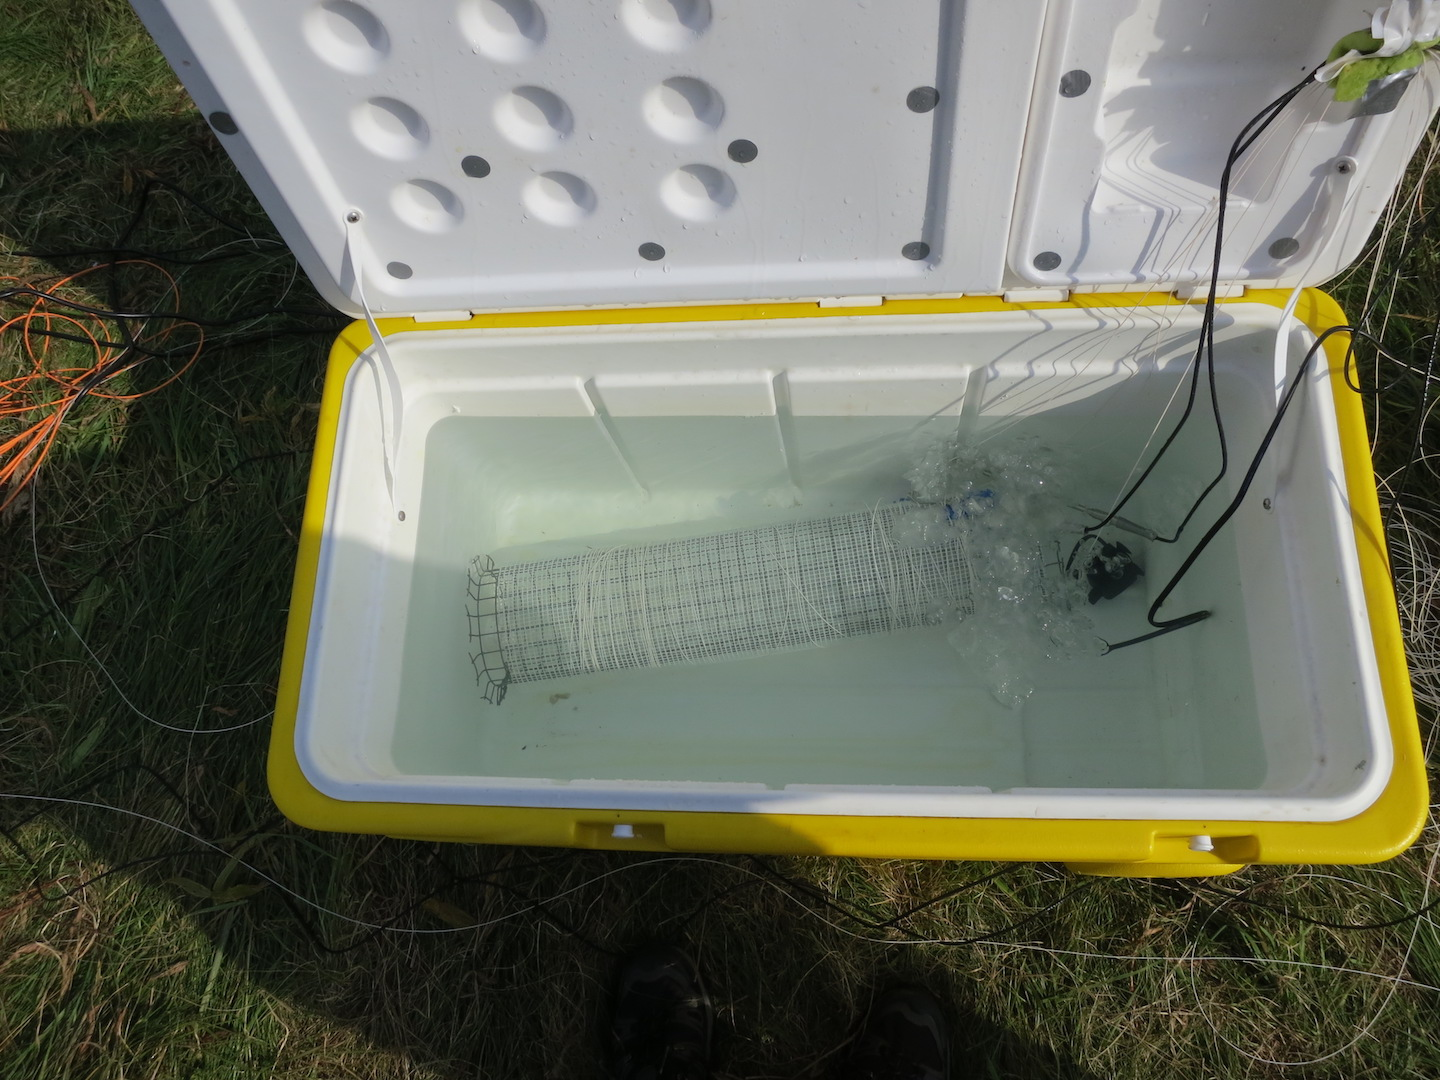

In [37]:
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/calibration_cold_bath.JPG')


In [39]:
hide_me = ''
HTML('''<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
    $('div.output_stderr').hide();
  });
</script>''')